In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import FastICA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin

In [3]:
def get_accuracy(model):

    print('-' * 80)
    print(f'\nMODEL: {model}\n')

    # Get sklearn accuracy score for given model; e.g., https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f'[*] Train Score: {str(train_score)}')
    print(f'[*] Test Score: {str(test_score)}')

    y_pred = model.predict(X_test)
    print('\n[*] Test Classification Report: \n', metrics.classification_report(y_test, y_pred))

    print('[*] Confusion Matrix on Test data')
    '''
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(range(2)), # length of unique values for label
    )
    '''
    cm = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f'[*] Test Accuracy: {str(round(test_score, 5) * 100)}%')
    print('-' * 80 + '\n')

def select_optimal_model_parameters(default_model, gridsearch_model):
    """ Calculates accuracy for the default and Gridsearch nominated parameters and appends the model with the highest accuracy to the model evaluation list """
    # save for selection comparison against GridSearch nomination
    y_pred = default_model.predict(X_test)
    default_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    y_pred = gridsearch_model.predict(X_test)
    gridsearch_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    # Compare the default and GridSearch paramaters for highest accuracy model to append to evaluation list
    if default_model_acc >= gridsearch_model_acc:
        print('Default parameter model selected')
        models.append(default_model)
    else:
        print('Gridsearch parameter model selected')
        models.append(gridsearch_model)

In [4]:
def plot_learning_curve(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.show()

def plot_validation_curve(clf, X_train, y_train, param_name, cv):
    # Define the hyperparameter range
    param_range = np.arange(1, 21)

    # Calculate training and validation scores over the specified hyperparameter range
    train_scores, test_scores = validation_curve(
        clf, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=-1
    )

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title('Model Complexity Graph')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [5]:
from scipy.stats import boxcox

models = []
file_path = "../notebooks/Airline Passenger Satisfaction.csv"
data = pd.read_csv(file_path)

ds=data
ds["Arrival Delay in Minutes"].fillna(0, inplace=True)
ds["Flight Distance"] = boxcox(ds["Flight Distance"])[0]
ds["Arrival Delay in Minutes"] = np.sqrt(np.log1p(ds["Arrival Delay in Minutes"]))
ds["Departure Delay in Minutes"] = np.sqrt(np.log1p(ds["Departure Delay in Minutes"]))

scols = ds.select_dtypes(object).columns
for col in scols:
    ds[col] = LabelEncoder().fit_transform(ds[col])
    
y = ds["satisfaction"]
ds = pd.DataFrame(StandardScaler().fit_transform(ds.iloc[:, :-1]), columns=ds.columns[:-1])
X=ds

C:\Users\abhis\AppData\Local\Temp\ipykernel_31604\3953601028.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ds["Arrival Delay in Minutes"].fillna(0, inplace=True)


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply ICA
number_components = 15
ica = FastICA(n_components=15, random_state=42)
X_ica = ica.fit_transform(X)


In [7]:
from sklearn.mixture import GaussianMixture

# Initialize EM model
em_model = GaussianMixture(n_components=2, random_state=42)  # Assuming 2 components for benign and malware classes

# Fit the EM model on the preprocessed data
em_model.fit(X_ica)

# Predict the latent variables (cluster assignments) using the trained EM model
latent_variables = em_model.predict(X_ica)

# Update the 'Class' labels based on the predicted latent variables
predicted_labels = [0 if latent == 0 else 1 for latent in latent_variables]

# Evaluate the performance of the EM model
accuracy = accuracy_score(y, predicted_labels)
print("Accuracy of EM model:", accuracy)

Accuracy of EM model: 0.7400378585642867


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming you've loaded the dataset and preprocessed it as mentioned in your code

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ica, y, test_size=0.2, random_state=42)

# Initialize Gaussian Mixture Model
num_clusters = 2  # You may adjust the number of clusters based on your scenario
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
# Fit the model on training data
gmm.fit(X_train)

# Predict labels for the training and testing data
train_predictions = gmm.predict(X_train)
test_predictions = gmm.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

# Additional evaluation metrics
print("\nClassification Report (Testing Data):\n", classification_report(y_test, test_predictions))


Training Accuracy: 0.469542531246208
Testing Accuracy: 0.4765833535549624

Classification Report (Testing Data):
               precision    recall  f1-score   support

           0       0.53      0.76      0.62      4716
           1       0.24      0.10      0.14      3526

    accuracy                           0.48      8242
   macro avg       0.38      0.43      0.38      8242
weighted avg       0.40      0.48      0.42      8242



╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 2   ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 4   ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 6   ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 8   ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 10  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 15  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 20  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 25  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 30  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 35  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 40  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CL

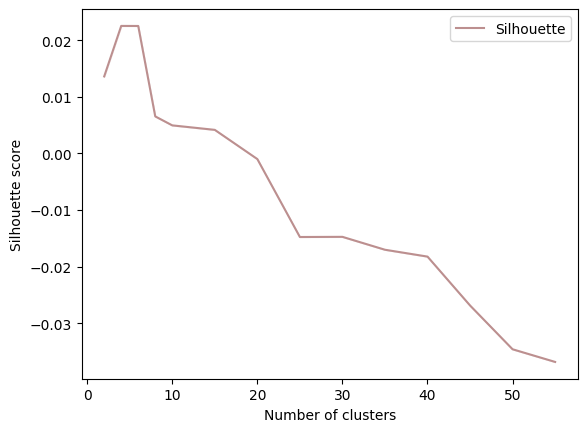

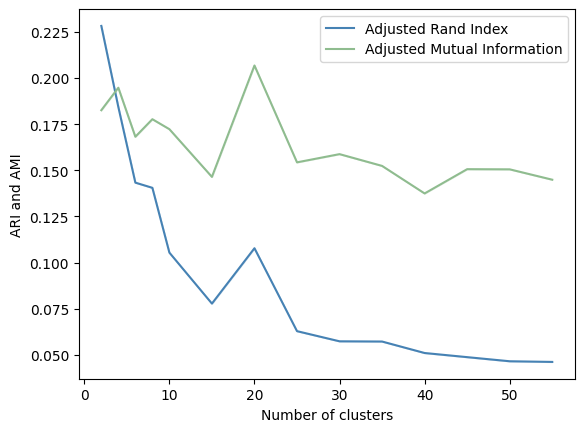

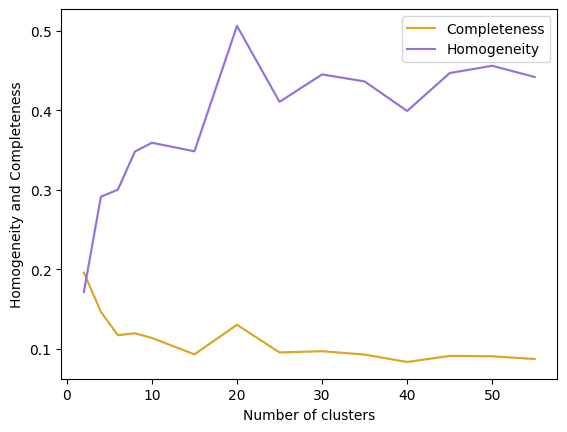

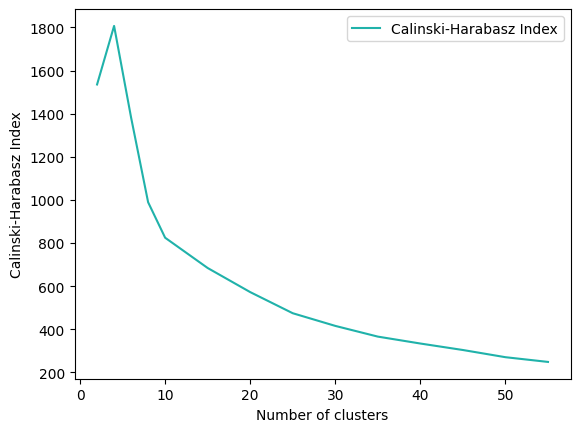

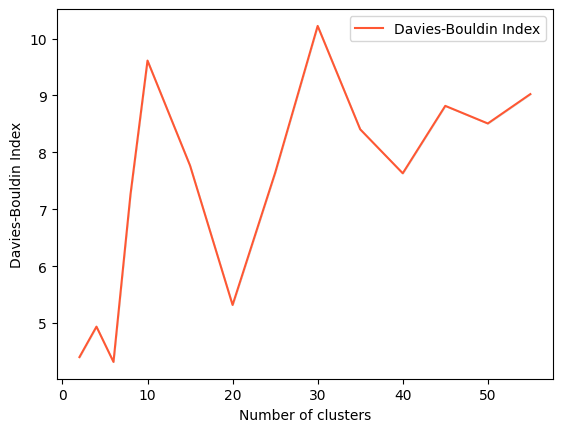

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score, completeness_score, homogeneity_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import LabelEncoder

ks = [2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

min_sil = []
min_ari = []
min_ami = []
min_com = []
min_hom = []
min_chi = []

avg_sil = []
avg_ari = []
avg_ami = []
avg_com = []
avg_hom = []
avg_chi = []

max_sil = []
max_ari = []
max_ami = []
max_com = []
max_hom = []
max_chi = []
min_davies_bouldin = []
avg_davies_bouldin = []
max_davies_bouldin = []

for k in ks:
    print("╔══════════════════════════╗")
    print("║ NUMBER OF CLUSTERS = {:<3} ║".format(k))
    print("╚══════════════════════════╝")

    sil = []
    ari = []
    ami = []
    com = []
    hom = []
    chi = []
    davies_bouldin_scores = []

    labs = GaussianMixture(n_components=k, random_state=42).fit_predict(X_ica)
    sil.append(silhouette_score(X_ica, labs))
    ari.append(adjusted_rand_score(y, labs))
    ami.append(adjusted_mutual_info_score(y, labs))
    com.append(completeness_score(y, labs))
    hom.append(homogeneity_score(y, labs))
    chi.append(calinski_harabasz_score(X_ica, labs))
    davies_bouldin = davies_bouldin_score(X_ica, labs)
    davies_bouldin_scores.append(davies_bouldin)

    min_davies_bouldin.append(np.amin(davies_bouldin_scores))
    avg_davies_bouldin.append(np.mean(davies_bouldin_scores))
    max_davies_bouldin.append(np.amax(davies_bouldin_scores))

    min_sil.append(np.amin(sil))
    avg_sil.append(sum(sil) / len(sil))
    max_sil.append(np.amax(sil))

    min_ari.append(np.amin(ari))
    avg_ari.append(sum(ari) / len(ari))
    max_ari.append(np.amax(ari))

    min_ami.append(np.amin(ami))
    avg_ami.append(sum(ami) / len(ami))
    max_ami.append(np.amax(ami))

    min_com.append(np.amin(com))
    avg_com.append(sum(com) / len(com))
    max_com.append(np.amax(com))

    min_hom.append(np.amin(hom))
    avg_hom.append(sum(hom) / len(hom))
    max_hom.append(np.amax(hom))

    min_chi.append(np.amin(chi))
    avg_chi.append(sum(chi) / len(chi))

# Plots
fig, ax = plt.subplots()
ax.plot(ks, avg_sil, color='RosyBrown', label='Silhouette')
ax.fill_between(ks, min_sil, max_sil, color='RosyBrown', alpha=0.15)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ks, avg_ari, color='SteelBlue', label='Adjusted Rand Index')
ax.plot(ks, avg_ami, color='DarkSeaGreen', label='Adjusted Mutual Information')
ax.fill_between(ks, min_ari, max_ari, color='SteelBlue', alpha=0.15)
ax.fill_between(ks, min_ami, max_ami, color='DarkSeaGreen', alpha=0.15)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('ARI and AMI')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ks, avg_com, color='Goldenrod', label='Completeness')
ax.plot(ks, avg_hom, color='MediumPurple', label='Homogeneity')
ax.fill_between(ks, min_com, max_com, color='Goldenrod', alpha=0.15)
ax.fill_between(ks, min_hom, max_hom, color='MediumPurple', alpha=0.15)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Homogeneity and Completeness')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ks, avg_chi, color='LightSeaGreen', label='Calinski-Harabasz Index')
# ax.fill_between(ks, min_chi, max_chi, color='LightSeaGreen', alpha=0.15)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski-Harabasz Index')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ks, avg_davies_bouldin, color='#FF5733', label='Davies-Bouldin Index')
ax.fill_between(ks, min_davies_bouldin, max_davies_bouldin, color='LightSeaGreen', alpha=0.15)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies-Bouldin Index')
plt.legend()
plt.show()

╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 2   ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 4   ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 6   ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 8   ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 10  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 15  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 20  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 25  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 30  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 35  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CLUSTERS = 40  ║
╚══════════════════════════╝
╔══════════════════════════╗
║ NUMBER OF CL

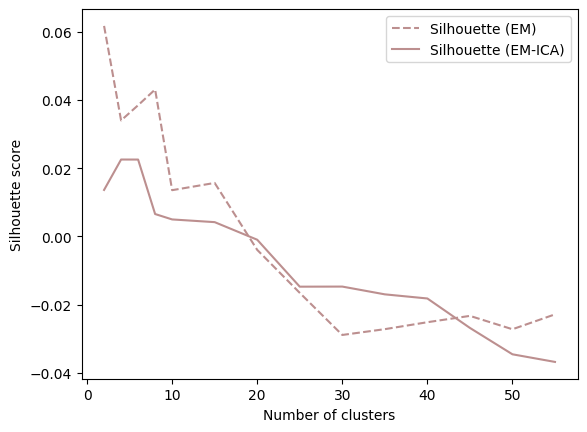

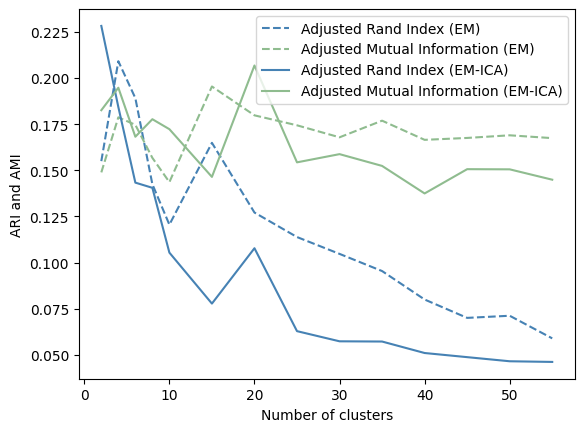

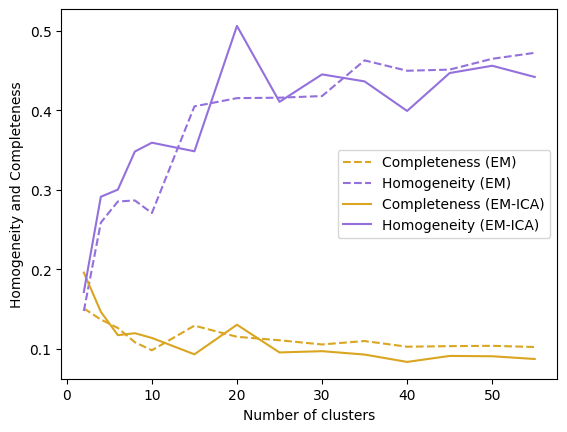

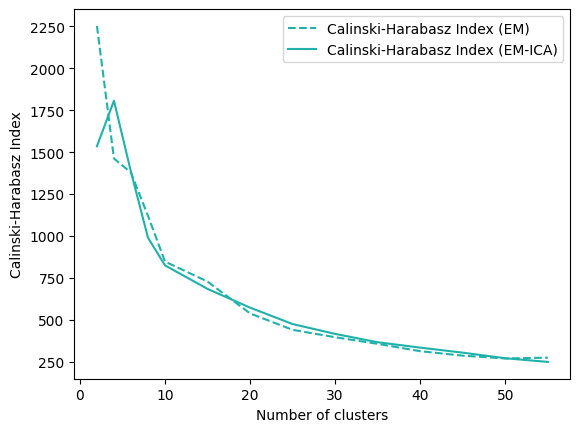

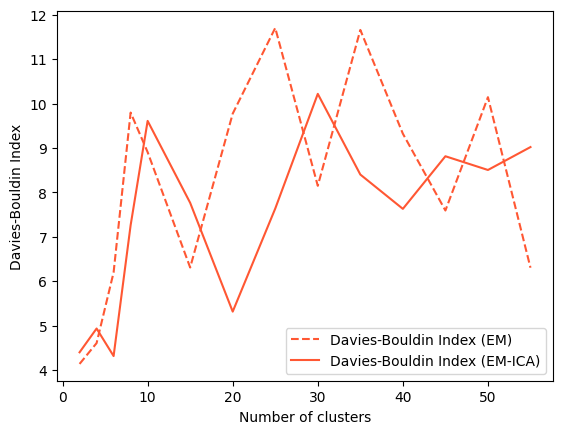

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score, completeness_score, homogeneity_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import LabelEncoder

ks = [2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

avg_sil_without_dr = []
avg_ari_without_dr = []
avg_ami_without_dr = []
avg_com_without_dr = []
avg_hom_without_dr = []
avg_chi_without_dr = []
avg_davies_bouldin_without_dr = []


for k in ks:
    print("╔══════════════════════════╗")
    print("║ NUMBER OF CLUSTERS = {:<3} ║".format(k))
    print("╚══════════════════════════╝")

    sil = []
    ari = []
    ami = []
    com = []
    hom = []
    chi = []
    davies_bouldin_scores = []

    labs = GaussianMixture(n_components=k, random_state=42).fit_predict(X)
    sil.append(silhouette_score(X, labs))
    ari.append(adjusted_rand_score(y, labs))
    ami.append(adjusted_mutual_info_score(y, labs))
    com.append(completeness_score(y, labs))
    hom.append(homogeneity_score(y, labs))
    chi.append(calinski_harabasz_score(X, labs))
    davies_bouldin = davies_bouldin_score(X, labs)
    davies_bouldin_scores.append(davies_bouldin)

    avg_davies_bouldin_without_dr.append(np.mean(davies_bouldin_scores))

    avg_sil_without_dr.append(sum(sil) / len(sil))
    
    avg_ari_without_dr.append(sum(ari) / len(ari))
    
    avg_ami_without_dr.append(sum(ami) / len(ami))
    
    avg_com_without_dr.append(sum(com) / len(com))
    
    avg_hom_without_dr.append(sum(hom) / len(hom))
    
    avg_chi_without_dr.append(sum(chi) / len(chi))

# Plots
fig, ax = plt.subplots()
ax.plot(ks, avg_sil_without_dr, color='RosyBrown', label='Silhouette (EM)',linestyle='--')
ax.plot(ks, avg_sil, color='RosyBrown', label='Silhouette (EM-ICA)')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ks, avg_ari_without_dr, color='SteelBlue', label='Adjusted Rand Index (EM)',linestyle='--')
ax.plot(ks, avg_ami_without_dr, color='DarkSeaGreen', label='Adjusted Mutual Information (EM)',linestyle='--')
ax.plot(ks, avg_ari, color='SteelBlue', label='Adjusted Rand Index (EM-ICA)')
ax.plot(ks, avg_ami, color='DarkSeaGreen', label='Adjusted Mutual Information (EM-ICA)')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('ARI and AMI')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ks, avg_com_without_dr, color='Goldenrod', label='Completeness (EM)',linestyle='--')
ax.plot(ks, avg_hom_without_dr, color='MediumPurple', label='Homogeneity (EM)',linestyle='--')
ax.plot(ks, avg_com, color='Goldenrod', label='Completeness (EM-ICA)')
ax.plot(ks, avg_hom, color='MediumPurple', label='Homogeneity (EM-ICA)')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Homogeneity and Completeness')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ks, avg_chi_without_dr, color='LightSeaGreen', label='Calinski-Harabasz Index (EM)',linestyle='--')
ax.plot(ks, avg_chi, color='LightSeaGreen', label='Calinski-Harabasz Index (EM-ICA)')
# ax.fill_between(ks, min_chi, max_chi, color='LightSeaGreen', alpha=0.15)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski-Harabasz Index')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ks, avg_davies_bouldin_without_dr, color='#FF5733', label='Davies-Bouldin Index (EM)',linestyle='--')
ax.plot(ks, avg_davies_bouldin, color='#FF5733', label='Davies-Bouldin Index (EM-ICA)')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies-Bouldin Index')
plt.legend()
plt.show()